# Tutorial 2
# Parameter estimation from the weight of Honey-bee hives (step by step)
Here we will present the daily data processing of different honey hives 
  ## Packages needed : 


In [18]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import numpy as np
import time
import sympy as sp 
from numpy import genfromtxt
#from itertools import cycle
from numpy import random
from scipy import optimize
from numpy import vectorize
from scipy.optimize import fsolve
from scipy.integrate import quad
from collections import defaultdict
from tabulate import tabulate
import scipy.optimize
from sklearn.linear_model import LinearRegression
from src.source_codes import * 

# Tutorial

## 1. Choose your dataset:

1. Save your daily data in .csv format. The first column must contains the time recorded in minutes and the second column must contain the weight recorded in kg

In [19]:
my_data = genfromtxt('data/Hive_6.csv', delimiter=',')
col_names=["time [min]", "Weight [Kg]" ]
#print(tabulate(my_data, headers=col_names, tablefmt='fancy_grid'))
T_raw= (my_data[:,0])
W_raw=(my_data[:,1])*1000
data=(T_raw,W_raw)

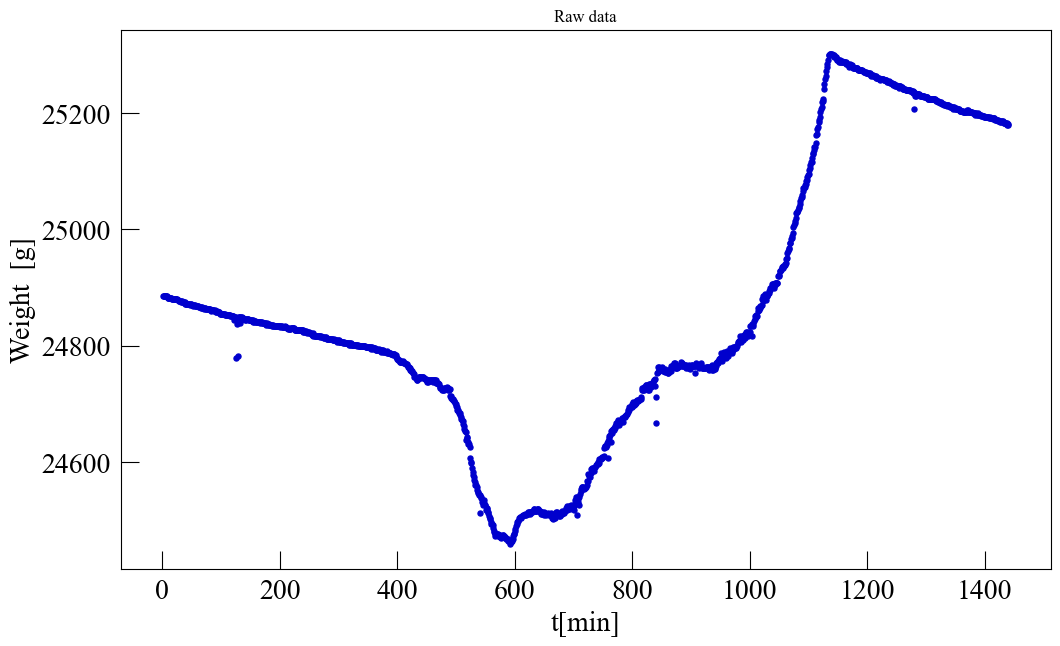

In [20]:
fig=plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)

ax1.scatter(data[0],data[1],color ="#0000CD",s=13)
ax1.set_ylabel('Weight  [g]',fontname="Times New Roman",fontsize=20)
ax1.set_xlabel('t[min]',fontname="Times New Roman",fontsize=20)
            
ax1.tick_params(axis="y",direction="in", pad=7, length=13,labelsize=20)
ax1.tick_params(axis="x",direction="in", pad=7, length=13,labelsize=20)
ax1.title.set_text("Raw data")#,fontsize=20)

2. Remove outliers:

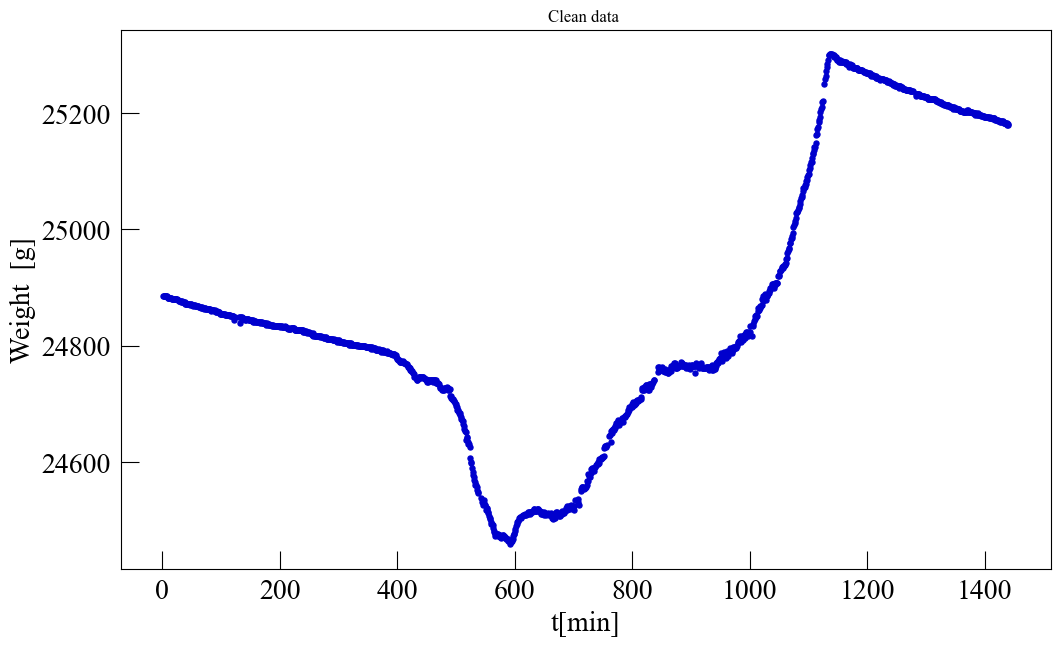

In [21]:
T,W= FilterErrors(T_raw,W_raw)
fig=plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.scatter(T,W,color ="#0000CD",s=13)
ax1.set_ylabel('Weight  [g]',fontname="Times New Roman",fontsize=20)
ax1.set_xlabel('t[min]',fontname="Times New Roman",fontsize=20)
            
ax1.tick_params(axis="y",direction="in", pad=7, length=13,labelsize=20)
ax1.tick_params(axis="x",direction="in", pad=7, length=13,labelsize=20)
ax1.title.set_text("Clean data ")#,fontsize=20)

## 2. Estimation of the robust parameters:
### 2.1 Estimation of  $t_0$ and $t_1$:

2. Calculate the scaling terms $t_{0}$ and $t_{1}$ to calibrate the model, we proposed three different methods:
- Method 1: Multigrid or contour plot performing multiple minimizations for different combinations of  $t_{0}$ and $t_{1}$ (Table 2).
- Method 2: The scaling terms can be defined by calculating twice the cumulative standard deviation of $\Delta$ Weight, from right to left and left to right. Then, we get $t_0$ and $t_1$ from the midpoint between the inflection points before the two largest changes of $\Delta$ Weight.
- Method 3: Through observation, one can define the scaling terms $t_0$ and $t_1$ before the abrupt decline and increase in hives' weight. However, it is not recommended.

In [22]:
parameters={}
t0,t1= FitTs(T,W)
print("t0=",t0,"min")
print("t1=",t1,"min")
parameters["t0"]=t0/60 #8.20 # Units [h]
parameters["t1"]=t1/60 #18.26 # Units [h]

t0= 484.0 min
t1= 1066.5 min


In [23]:
t=Trescaled(T,parameters["t0"],parameters["t1"])

### 2.2 Estimation of l, A,B, $\alpha$ and $t_{c}$ parameter: 

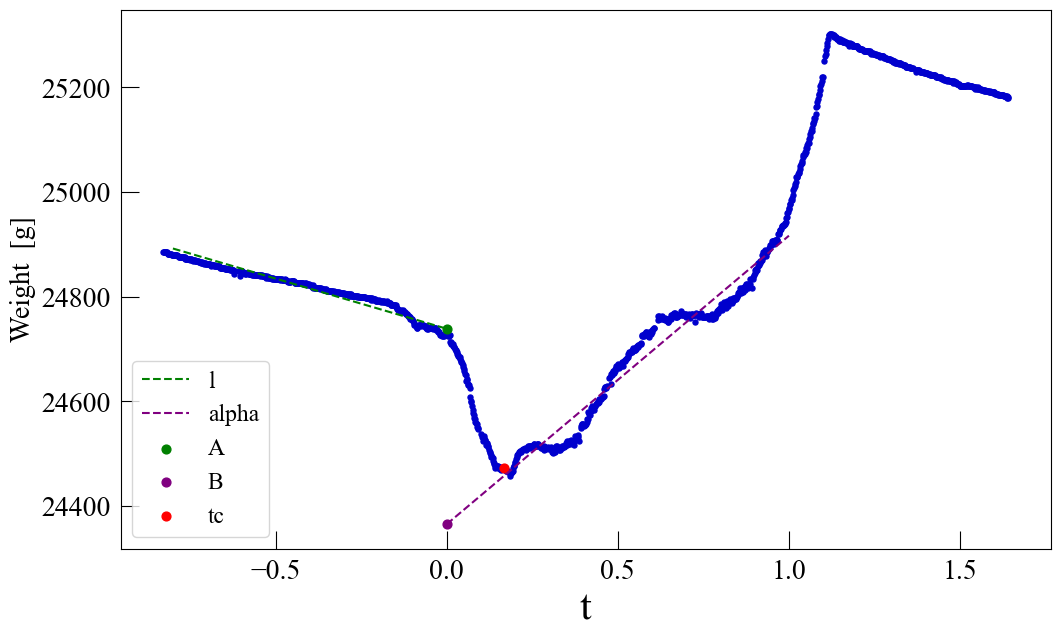

In [24]:
l,A,tc,W_tc=RobustParameters_1(t,W)
parameters["l_0"]=-l
parameters["A"]=A
parameters["tc"]=tc[0]#0.138#

alpha,B=RobustParameters_2(t,W,parameters["tc"])
parameters["alpha"]=alpha
parameters["B"]=B


fig=plt.figure(figsize=(12,7))
xspace_1=np.linspace(-0.8, 0.0, num=30)
xspace_2=np.linspace(0, 1, num=30)
ax1 = fig.add_subplot(111)
ax1.scatter(t,W,color ="#0000CD",s=13)
ax1.plot(xspace_1,Line(xspace_1,l,A),color="green", linestyle='--',label="l")
ax1.plot(xspace_2,Line(xspace_2,alpha,B),color="purple", linestyle='--',label="alpha")
ax1.scatter(0,A,color ="green",s=40, label="A")
ax1.scatter(0,B,color ="purple",s=40, label="B")
ax1.scatter(parameters["tc"],W_tc[0],color ="red",s=40, label="tc")

    
ax1.set_ylabel('Weight  [g]',fontname="Times New Roman",fontsize=20)
ax1.set_xlabel('t',fontname="Times New Roman",fontsize=30)
            
ax1.tick_params(axis="y",direction="in", pad=7, length=13,labelsize=20)
ax1.tick_params(axis="x",direction="in", pad=7, length=13,labelsize=20)
ax1.legend(loc='lower left',fontsize=17)

In [25]:
parameters

{'t0': 8.066666666666666,
 't1': 17.775,
 'l_0': 191.53691704509595,
 'A': 24738.907355382795,
 'tc': 0.1682403433476395,
 'alpha': 551.1537483517662,
 'B': 24365.5052842708}

## 3. Fit the other model parameters

 The number of possible forager bees $N_{max}$ should be chosen within a valid interval, otherwise predefine a $d$ value. From the robust parameters we calculate the fitting model parameters.

In [26]:
#N,W0,a1,a2,d,m,l,Error=fitParameters(t,W,to,t1,d,l,A,B,alpha,tc)
N,W0,a1,a2,d,m,l_f,Error=fitParameters(t,W,parameters["t0"],parameters["t1"],0.854,parameters["l_0"],parameters["A"],parameters["B"],parameters["alpha"],parameters["tc"])

final_parameters={}

final_parameters["a1"]=a1
final_parameters["a2"]=a2
final_parameters["d"]=d
final_parameters["m"]=m
final_parameters["l"]=l_f
final_parameters["N"]=N
final_parameters["W0"]=W0


w_bee=0.113
scale=parameters["t1"]-parameters["t0"]
result=np.array([a1*scale,a2*scale,d*scale,m,N,w_bee,W0,l_f*scale])
delta_time = parameters["t1"]-parameters["t0"]
time_0=parameters["t0"]/delta_time
time_1=(24-parameters["t1"])/delta_time
interval=np.array(time_0+time_1+1)


In [27]:
final_parameters


{'a1': 0.5192,
 'a2': 1.6966,
 'd': 0.8539,
 'm': 0.0555,
 'l': 21.2281,
 'N': 4085.0,
 'W0': 24270.311}

## Plot results

Text(0.5, 0, 't [h]')

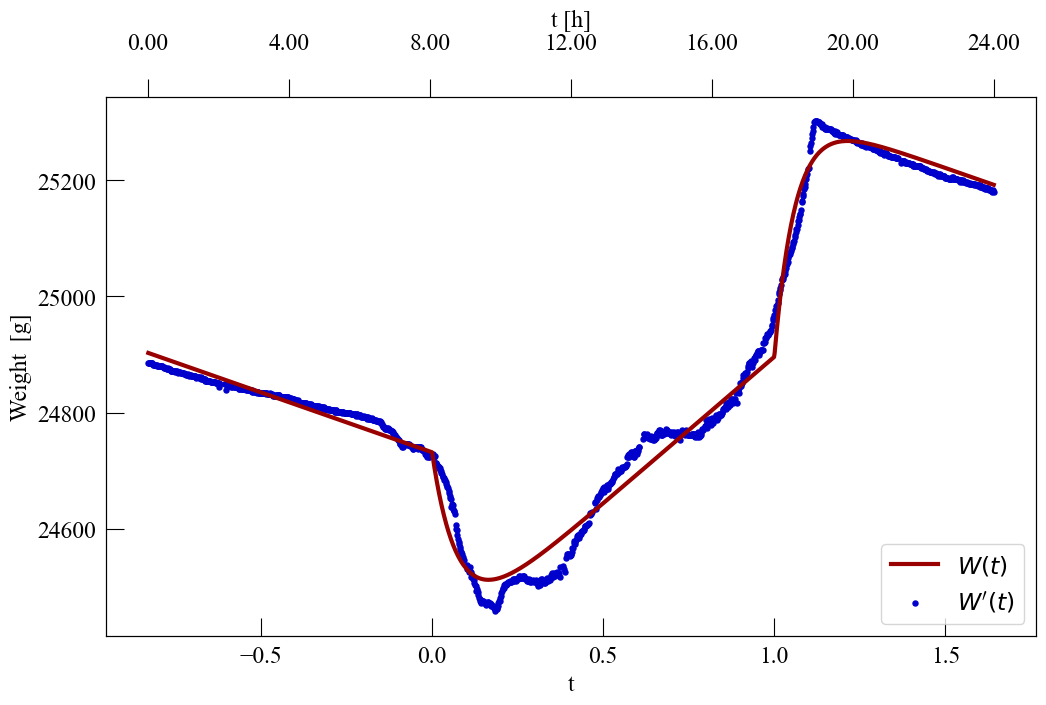

In [28]:
fig=plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

    
ax1.plot(t, Wfunc(t, *result) ,color ="#990000", linestyle='-',linewidth=3.0) #..Plotting our results
ax1.scatter(t,W,color ="#0000CD",s=13) #.........................................Plotting original data
   
ax1.legend([ "$W(t)$","$W'(t)$"], loc ="lower right",fontsize=17)
ax1.set_ylabel('Weight  [g]',fontname="Times New Roman",fontsize=17)
ax1.set_xlabel('t',fontname="Times New Roman",fontsize=17)
            
ax1.tick_params(axis="y",direction="in", pad=7, length=13,labelsize=17)
ax1.tick_params(axis="x",direction="in", pad=7, length=13,labelsize=17)

def tick_function(X):
     V = (X+time_0)/interval * 1440/60
     return ["%.2f" % z for z in V]
            
hours=np.array([0.0, 4. , 8. , 12. ,16. , 20. ,24.])
new_tick_locations=(hours*60*interval/1440)-time_0
            
ax2.set_xlim(ax1.get_xlim()) 
ax2.set_xticks(new_tick_locations) 
ax2.set_xticklabels(tick_function(new_tick_locations)) 
ax2.tick_params(axis="x",direction="out", pad=18, length=13,labelsize=17) 
ax2.set_xlabel("t [h]",fontname="Times New Roman",fontsize=17) 

Function to compute $R^2$ between a given data and model parameters

In [29]:
Err_unit=np.sum((W-Wfunc(t, *result))**2)/len(W)
print("Error=",Err_unit)
final_parameters["Error"]=Err_unit


Error= 632.3485091758314


The output of function is a dictionary with all parameters called final_parameters:  

In [30]:
final_parameters

{'a1': 0.5192,
 'a2': 1.6966,
 'd': 0.8539,
 'm': 0.0555,
 'l': 21.2281,
 'N': 4085.0,
 'W0': 24270.311,
 'Error': 632.3485091758314}

## 4. Useful functions

Function 'Wfunc' computes the weight from the measured weight $W'$. Here we obtain different mathematical solutions for the same data set.  The calculation is made from the robust parameters but pre-defining a different $d$ value. Just for this example, we extend the prior(bounds). Consequently, some of these solutions minimize the error, but the parameters exceed feasible values (see table-$\color{red}{red}$).

Text(0.5, 1.3, 'Feasible parameter set (Black color)')

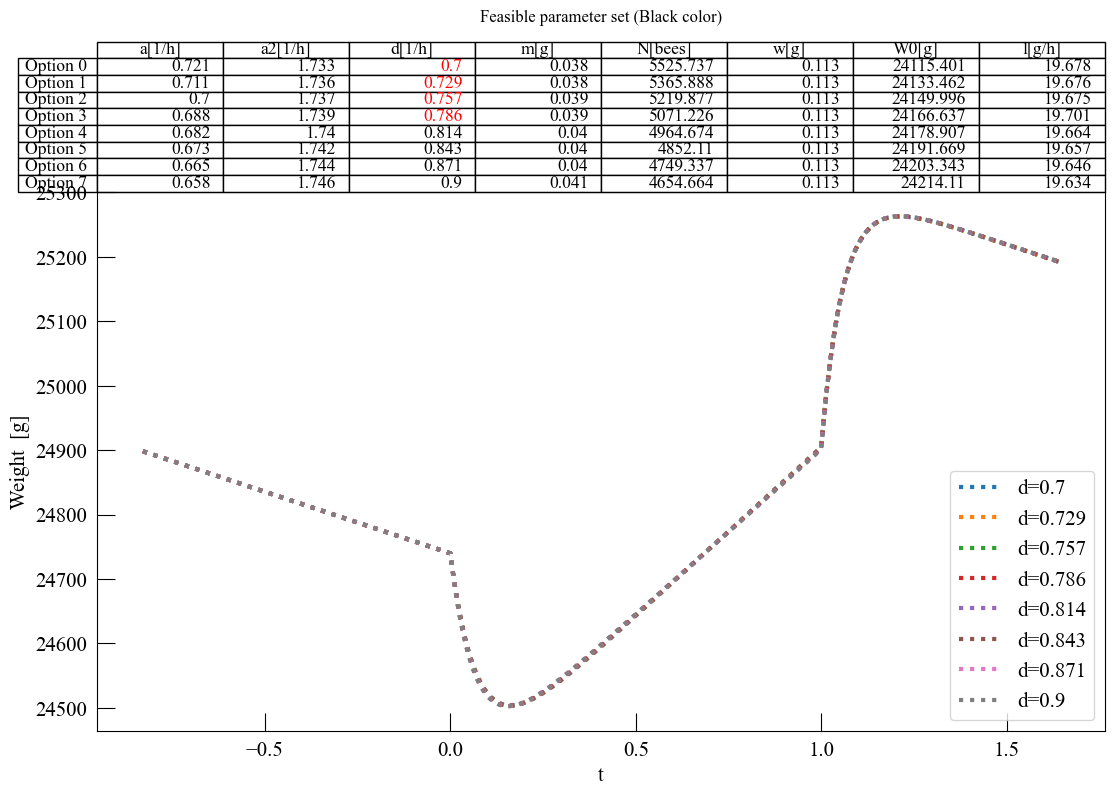

In [31]:
#> Multiple solutions fixing d value:
fig=plt.figure(figsize=(13,7))
ax1 = fig.add_subplot(111)
d_i=np.linspace(0.7, 0.9, num=8)
Result=[]
for i in range (len(d_i)):
    d=d_i[i]*scale
    argument_1=(d,parameters["alpha"],parameters["A"],parameters["B"],parameters["tc"])
    a_1=scipy.optimize.fsolve(fun_a1,100, args=argument_1)[0]
    N=parameters["alpha"]/(w_bee*d*np.exp(-parameters["tc"]*(d+a_1)))-(parameters["alpha"]+final_parameters["l"]*scale)/(w_bee*d)
    m=(parameters["alpha"]+final_parameters["l"]*scale)/N*(a_1+d)/(a_1*d)
    argument_2=(parameters["t0"],parameters["t1"],a_1,d)
    a2_0=scipy.optimize.fsolve(fun_a2,17, args=argument_2)[0]
    result,pcov = optimize.curve_fit(Wfunc, t, W,p0=[a_1,a2_0, d, m,N,w_bee,W0,final_parameters["l"]*scale],bounds=([0,0,0.9999*d,0 ,0, w_bee*0.999999,0,0], [np.inf,np.inf,d,np.inf,np.inf,w_bee,np.inf,np.inf]),maxfev=10000)
    # From results, we scale a_1,a_2,d and l:
    Result.append([result[0]/scale,result[1]/scale,result[2]/scale,result[3],result[4],result[5],result[6],result[7]/scale])
    ax1.plot(t, Wfunc(t, *result), linestyle=':',linewidth=3.0,label="d="+str(np.round(d/scale,3))) #Plotting our Wfunc
    
#> Format for the figure:
ax1.set_ylabel('Weight  [g]',fontname="Times New Roman",fontsize=15)
ax1.set_xlabel('t',fontname="Times New Roman",fontsize=15)
ax1.tick_params(axis="y",direction="in", pad=7, length=13,labelsize=15)
ax1.tick_params(axis="x",direction="in", pad=7, length=13,labelsize=15)
ax1.legend(loc='lower right',fontsize=15)

#> Format for the table:
col_names = ["a[1/h]","a2[1/h]","d[1/h]","m[g]","N[bees]","w[g]","W0[g]","l[g/h]"]
rows = ['Option %d ' % x for x in range(len(d_i))]
the_table = ax1.table(cellText=np.round(Result,3),
                      rowLabels=rows,
                      rowColours=None,
                      colLabels=col_names,
                      loc='top')
the_table.set_fontsize(12.7)

#> Filtering in red results that exceed feasible values of our Table No 1:
Result = np.asarray(Result)
for i in range(len(d_i)):
    if Result[i,0]>= 0.20 and Result[i,0]<= 4.80: #arrival rate 1
        cell = the_table[i+1,1]
        cell.get_text().set_color('black')
    else: 
        cell.get_text().set_color('red')   
        
    if Result[i,1]>= 0.20 and Result[i,1]<= 4.80: #arrival rate 2
        cell = the_table[i+1,2]
        cell.get_text().set_color('black')
    else: 
        cell.get_text().set_color('red')
        
    if Result[i,2]>= 0.81 and Result[i,2]<= 3.01: #departure rate 1
        cell = the_table[i+1,3]
        cell.get_text().set_color('black')
    else: 
        cell.get_text().set_color('red')
        
    if Result[i,3]>= 0 and Result[i,3]<= 0.78*w_bee:   #Food carried per trip
        cell = the_table[i+1,4]
        cell.get_text().set_color('black')
    else: 
        cell.get_text().set_color('red')
    
    if Result[i,4]>= 0 and Result[i,4]<= 80000:        #Number of bees
        cell = the_table[i+1,5]
        cell.get_text().set_color('black')
    else: 
        cell.get_text().set_color('red')
        
    if Result[i,6]>= 5000 and Result[i,6]<= np.max(W): #Initial weight of the hive
        cell = the_table[i+1,7]
        cell.get_text().set_color('black')
    else: 
        cell.get_text().set_color('red')


ax1.set_title('Feasible parameter set (Black color)', y=1.3,fontdict=None, loc='center', pad=None)

## 5. Other Examples: 


From here we join all the previous command lines in a unique function:
- Model_Estimation: Imports the data set from 'csv' file and allows to fixing the $\color{blue}d$ value. Additionally, the user can input the $t_c$ value directly. Otherwise, the function will calculate the best $t_c$ that minimizes the error overall.  

Calibrating the model using my_fitting('Name.csv',$\color{blue}d$, $t_0$,$t_1$,$\color{red}{optional=t_c}$) 

╒═══════════╤═════════╤══════════╤═══════════╤══════════╤════════╤══════════╤═════════════╕
│   N[bees] │   W0[g] │   a[1/h] │   a2[1/h] │   d[1/h] │   m[g] │   l[g/h] │   Error$^2$ │
╞═══════════╪═════════╪══════════╪═══════════╪══════════╪════════╪══════════╪═════════════╡
│      4085 │ 24270.3 │   0.5192 │    1.6966 │   0.8539 │ 0.0555 │  21.2281 │     632.248 │
╘═══════════╧═════════╧══════════╧═══════════╧══════════╧════════╧══════════╧═════════════╛


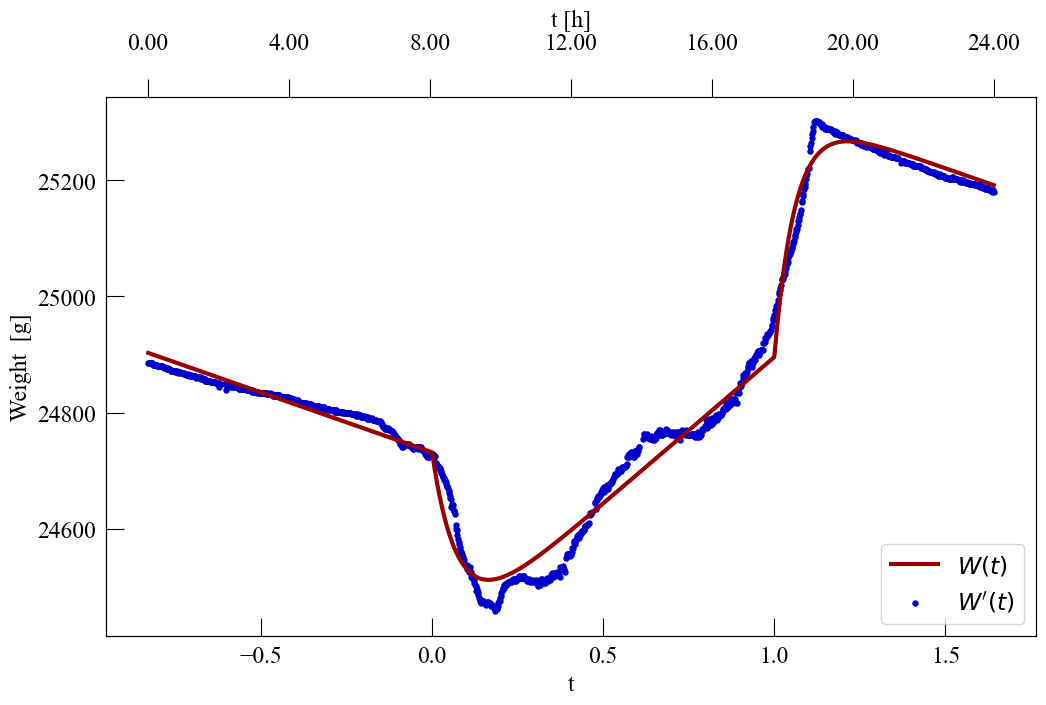

In [32]:
r=Model_Estimation('data/Hive_6.csv',0.854,parameters["t0"],parameters["t1"],9.70)
model_parameters={}
model_parameters["a1"]=r[0][2]
model_parameters["a2"]=r[0][3]
model_parameters["d"]= r[0][4]
model_parameters["m"]= r[0][5]
model_parameters["l"]= r[0][6]
model_parameters["N"]= r[0][0]
model_parameters["W0"]=r[0][1]

In this example we reproduce the result stored in variable "final_parameters" from Item 3.0

In [33]:
model_parameters

{'a1': 0.5192,
 'a2': 1.6966,
 'd': 0.8539,
 'm': 0.0555,
 'l': 21.2281,
 'N': 4085.0,
 'W0': 24270.311}

╒═══════════╤═════════╤══════════╤═══════════╤══════════╤════════╤══════════╤═════════════╕
│   N[bees] │   W0[g] │   a[1/h] │   a2[1/h] │   d[1/h] │   m[g] │   l[g/h] │   Error$^2$ │
╞═══════════╪═════════╪══════════╪═══════════╪══════════╪════════╪══════════╪═════════════╡
│      4812 │ 24196.3 │   0.6701 │     1.743 │   0.8539 │ 0.0402 │   19.652 │     601.377 │
╘═══════════╧═════════╧══════════╧═══════════╧══════════╧════════╧══════════╧═════════════╛


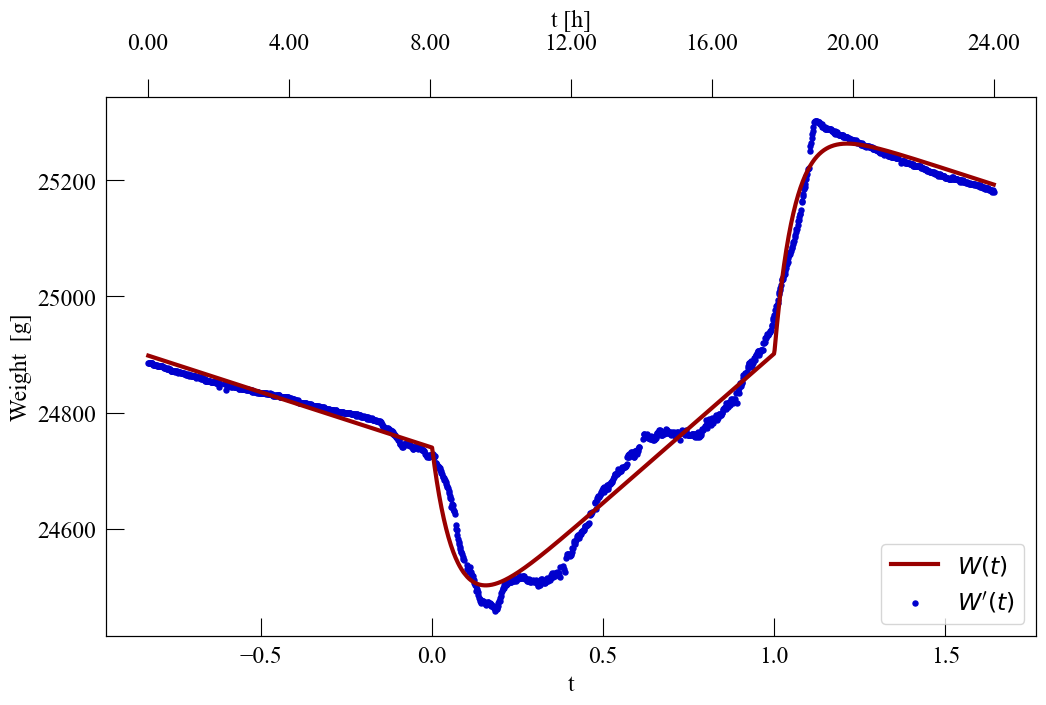

In [34]:
r=Model_Estimation('data/Hive_6.csv',0.854,parameters["t0"],parameters["t1"])